# Assignment 2
Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between `Master semestre 1` and `Master semestre 2`. If the Mineur field is not empty, the student should also appear registered in `Master semestre 3`. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master` tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a `Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

Useful usual imports at first

In [25]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import html5lib 
from lxml import html
import numpy as np
from helpers import *
#import helpers as helpers

Extracting the master students in the similar fashion we did in the first assignment : we associate each year/master stage with its value, that we extract from the html page using the BeautifulSoup package.

In [26]:
# The URL of the "start" of the IS-Academia page listing the students.
home_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_x_GPS=-1&ww_i_reportModel=133685247"

# The general form of the URL, with the fields to be replaced later (e.g. [UNITE_ACADEMIQUE])
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=[UNITE_ACADEMIQUE]&ww_x_PERIODE_ACAD=[PERIODE_ACADEMIQUE]&ww_x_PERIODE_PEDAGO=[PERIODE_PEDAGOGIQUE]&ww_x_HIVERETE=null"

# Get the raw content from the page
with urllib.request.urlopen(home_url) as url:
    s = url.read()

soup = BeautifulSoup(s, 'html.parser')

# Parse the content
url_section = 0
url_years = {}
url_master = {}

#For loop on all the possible fields with <option> to get the value associated with each year, or each "Bachelor" semester
for link in soup.find_all('option'):
    if link.text == 'Informatique':
        url_section = link.get('value')
    if "20" in link.text:
        url_years[link.text] = link.get('value')
    if 'Master' in link.text or 'Mineur' in link.text:
        url_master[link.text] = link.get('value')

        
print(url_years)
print(url_master)

{'2015-2016': '213638028', '2011-2012': '123455150', '2013-2014': '213637754', '2007-2008': '978181', '2008-2009': '978187', '2009-2010': '978195', '2010-2011': '39486325', '2012-2013': '123456101', '2014-2015': '213637922', '2016-2017': '355925344'}
{'Mineur semestre 1': '2335667', 'Projet Master printemps': '3781783', 'Master semestre 1': '2230106', 'Master semestre 2': '942192', 'Master semestre 3': '2230128', 'Projet Master automne': '249127', 'Master semestre 4': '2230140', 'Mineur semestre 2': '2335676'}


Function that replaces the general fields in the base_url with the fields for a given year and level of study

In [27]:
def getFullUrl(PeriodeAcad, PeriodePedag):
    """
    Given an academic period (years) and a pedagogic period (bachelor semester), 
    fills the general URL with the values associated to those parameters.
    
    @param PeriodeAcad :  Academic year string, in the form ('2015-2016')
    @param PeriodePedag : Pedagogic period string, in the form ('Bachelor x')
    @return url :         The complete url associated to those period, from which we can fetch the students.
    
    """
    url = base_url
    url = url.replace('[UNITE_ACADEMIQUE]', str(url_section))
    url = url.replace('[PERIODE_ACADEMIQUE]', str(url_years[PeriodeAcad]))
    url = url.replace('[PERIODE_PEDAGOGIQUE]', str(url_master[PeriodePedag]))
    return url

We noticed that in the way the EPFL master works, we will have all students that start in the autumn semester in `MS1` and then moves onto the `MS2`, then every subsqeuent autumn semester that he does will be counted into `MS3`.

The way our data structure extracts the information we want from the table of students is as simple as possible. Keeping track of a student and noting each semester in which is present can be quite tricky, even very difficult, due to the holes into the IS-Academia data. The simplest way we found to address this problem is not trying to make any assumptions into where a student that disappears goes. We count each time a student appears in ones of the master semesters or master project semesters and add a $1$ each time we find an occurence of the same student. Hence its master duration will be the sum of the semesters in which the student appears.

In [28]:
def MasterStart(year,master_student,pedag) : 
    """
    Given a year and a pedagogic period, edits the master_student frame, adding the students 
    that are not present and editting the values for the ones present (adding a +1 for the pedagogic period)
    
    @param year_string :    Academic year string, in the form ('2015-2016')
    @param master_student : DataFrame containing the occurrence of each students into any possible semester of the master.
    @param pedag :          Pedagogic period string (e.g. in the form 'Master semestre x')
    @return master_student: The editted version of our DataFrame.
    
    """  
    year_string = str(year) + '-' + str(year+1)
    #Reading the HTML page
    current_url = getFullUrl(year_string, pedag)
    
    with urllib.request.urlopen(current_url) as url:
        html = url.read()
    soup = BeautifulSoup(html, 'html.parser')
    master_frame = pd.read_html(soup.prettify(), header=1)
    
    #If the page has actually some students in it.
    if  len(master_frame)>0 :
        master_frame = master_frame[0].drop(0,axis=0)
        master_frame_sciper = master_frame[['No Sciper']]
        master_frame = master_frame.set_index('No Sciper')
        for sciper in master_frame_sciper.values:
            sciper = sciper[0]
            
            #As a student can be in 'Master semestre 1' only once, we add all of them automatically.
            if pedag == 'Master semestre 1' or sciper not in master_student.index:
                master_student.loc[sciper] = 0   
                master_student.loc[sciper,pedag] = 1
                master_student.loc[sciper,'Starting Year'] = year
            else :
                master_student.loc[sciper,pedag] += 1   
            master_student.loc[sciper,'Civilité'] = master_frame.loc[sciper,'Civilité']
            master_student.loc[sciper,'Nom Prénom'] = master_frame.loc[sciper,'Nom Prénom']
            master_student.loc[sciper,'Spécialisation'] = master_frame.loc[sciper,'Spécialisation']
            master_student.loc[sciper,'Mineur'] = master_frame.loc[sciper,'Mineur']
    return master_student

We perform here the extraction from all the years and master stages for each student we find, going from the period $2007$ to $2016$, counting for each student. The following essentially calls the `MasterStart` function at each iteration.
 - If there are no entries in `Master semester 1`, we erase the student data if in 2007-2008

In [29]:
master_student = pd.DataFrame(columns = ['Civilité', 'Nom Prénom', 
                                         'Master semestre 1', 'Master semestre 2', 'Master semestre 3',
                                         'Projet Master printemps', 'Projet Master automne', 
                                         'Spécialisation', 'Mineur','Starting Year'])
master_student.index.name = 'No Sciper'

pedagogic_year = ['Master semestre 1','Master semestre 2','Master semestre 3',
                  'Projet Master printemps','Projet Master automne']
for year in range(2007,2016):
    
    for pedag in  pedagogic_year :
         master_student = MasterStart(year,master_student,pedag)


In [30]:
master_student = master_student[np.logical_not((master_student['Starting Year'] ==2007)&(master_student['Master semestre 1']==0))]
master_student = master_student[np.logical_not((master_student['Starting Year'] ==2015)&(master_student['Master semestre 1']==1))]
course_time = (master_student['Master semestre 1']+master_student['Master semestre 2']+
        master_student['Master semestre 3']+master_student['Projet Master printemps']+
        master_student['Projet Master automne'])
master_student = master_student[course_time>1]
master_student.sort_values(ascending =[True, True],by=['Master semestre 1','Master semestre 2'])
#master_student.sort_values(ascending =[False,True],by=['Master semestre 1','Master semestre 2'])

,Civilité,Nom Prénom,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master printemps,Projet Master automne,Spécialisation,Mineur,Starting Year
No Sciper,,,,,,,,,,
170525,Monsieur,Galimberti Davide,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2008.0
175190,Monsieur,Hanser Valérian,0.0,1.0,1.0,1.0,0.0,NaN,NaN,2010.0
202878,Madame,Tapandjieva Gorica,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2010.0
184772,Monsieur,Arnfred Jonas,0.0,1.0,1.0,0.0,0.0,NaN,Area and Cultural Studies minor,2011.0
232468,Madame,Bagcioglu Egeyar Özlen,0.0,1.0,2.0,0.0,0.0,Internet computing,NaN,2014.0
170220,Monsieur,Barras Florian,0.0,2.0,1.0,0.0,0.0,NaN,"Mineur en Management, technologie et entrepren...",2009.0
199294,Monsieur,Jin Xuedong,0.0,2.0,1.0,0.0,0.0,NaN,"Mineur en Management, technologie et entrepren...",2010.0
212069,Madame,Le Danni,0.0,2.0,2.0,0.0,0.0,NaN,NaN,2011.0
186264,Monsieur,Bougacha Malik,0.0,2.0,1.0,0.0,0.0,NaN,NaN,2014.0


**Assumptions**  : 
 - It is possible to have project master in spring and autumn (not really an assumption, but we realise it's possible to fail the master project and redo it, so the data is valid).
 - If no `projet master` field has been found, we assume that the student had his project outside epfl and add $+1$ semester to the total duration of his master.


In [31]:
print(master_student.index.is_unique)
## sum over all the master 1,2,3 plus additional master project.
## The two long lines starting with one add a semester to the master for students having :
## 0 semesters in MS1, MS2 // 0 semesters in Master project autumn/spring

time = (course_time + 1-((master_student['Projet Master printemps']+ master_student['Projet Master automne'])>=1)) 
master_student['Time to Finish']= time
master_student.sort_values(ascending=[True,True],by=['Master semestre 1', 'Master semestre 2']).head(10)

True


,Civilité,Nom Prénom,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master printemps,Projet Master automne,Spécialisation,Mineur,Starting Year,Time to Finish
No Sciper,,,,,,,,,,,
170525,Monsieur,Galimberti Davide,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2008.0,3
175190,Monsieur,Hanser Valérian,0.0,1.0,1.0,1.0,0.0,NaN,NaN,2010.0,3
202878,Madame,Tapandjieva Gorica,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2010.0,3
184772,Monsieur,Arnfred Jonas,0.0,1.0,1.0,0.0,0.0,NaN,Area and Cultural Studies minor,2011.0,3
232468,Madame,Bagcioglu Egeyar Özlen,0.0,1.0,2.0,0.0,0.0,Internet computing,NaN,2014.0,4
170220,Monsieur,Barras Florian,0.0,2.0,1.0,0.0,0.0,NaN,"Mineur en Management, technologie et entrepren...",2009.0,4
199294,Monsieur,Jin Xuedong,0.0,2.0,1.0,0.0,0.0,NaN,"Mineur en Management, technologie et entrepren...",2010.0,4
212069,Madame,Le Danni,0.0,2.0,2.0,0.0,0.0,NaN,NaN,2011.0,5
186264,Monsieur,Bougacha Malik,0.0,2.0,1.0,0.0,0.0,NaN,NaN,2014.0,4


We now perform the statistical test to determine whether doing a specialisation effectively has an effect on the duration of the master. We chose a 1-sample t-test, as we want to compare if the difference from the mean duration of the master without any specialisation is statistically significant. Our null hypothesis is then that the two samples are from the ame distribution.

In [32]:
import scipy.stats as stats
specialisation = master_student[master_student['Spécialisation']==master_student['Spécialisation']]                        
mean_time_specialisation = specialisation['Time to Finish']
mean_time  = master_student['Time to Finish'].mean()
print(mean_time)
print(mean_time_specialisation.mean())
stats.ttest_1samp(a= mean_time_specialisation, 
                 popmean= mean_time)

4.17839607201
4.67914438503


Ttest_1sampResult(statistic=7.9861088560362354, pvalue=1.408381869015009e-13)

The result shows VERY clearly that the difference is meaningful, as the p-value is almost zero, rejecting our null hypothesis. We can see even by eye from the averages that we have at least a 0.5 longer master duration for the people doing a specialisation.

We will then compute the mean duration of the master for each of the different specialisations.

In [33]:
master_student_grouped = master_student.groupby(master_student.Spécialisation)
mean_spec = pd.DataFrame(columns=['Mean'])

for spec,student in master_student_grouped:
    #print('spec', spec)
    #print('student', student['Time to Finish'])
    mean_spec.loc[spec] = np.mean(student['Time to Finish'].values)

mean_spec

,Mean
Biocomputing,5.333333
Computer Engineering - SP,4.533333
Foundations of Software,4.678571
Information Security - SP,5.000000
Internet computing,4.628205
Service science,4.333333
"Signals, Images and Interfaces",5.000000
Software Systems,4.444444


In [34]:
#print(master_student.head(20))
#master_student = master_student.drop('Mineur', axis=1)

master_student_with_Spec = master_student[master_student.Spécialisation == master_student.Spécialisation]
list_Spec = master_student_with_Spec['Spécialisation'].drop_duplicates().values

#print(master_student_with_Spec.shape)
#print(master_student_with_Spec.sort_index().head())

master_student_with_Spec['No Sciper'] = master_student_with_Spec.index
master_student_with_Spec = master_student_with_Spec.set_index(['Spécialisation'])
master_student_with_Spec = master_student_with_Spec.sort_index()
master_student_with_Spec = master_student_with_Spec.set_index([master_student_with_Spec.index, 'No Sciper'])

master_student_with_Spec.head(10)

#print(master_student_with_Spec.head())


/Users/Barry/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Civilité              Nom Prénom  \
Spécialisation            No Sciper                                     
Biocomputing              183185       Madame          Yurovsky Alisa   
                          154573       Madame      Benabdallah Zeineb   
                          169734     Monsieur          Koller Yannick   
Computer Engineering - SP 211478     Monsieur    Vultur Remus-Gabriel   
                          201034     Monsieur  Kashani-Akhavan Sahand   
                          166262     Monsieur       Plancherel Pascal   
                          178271     Monsieur  Boéchat Marc-Alexandre   
                          191354     Monsieur              Önal Cagri   
                          218353     Monsieur  Favrod Philémon Orphée   
                          185005       Madame              Ilie Diana   

                                     Master semestre 1  Master semestre 2  \
Spécialisation            No Sciper                                         
Biocomputing              183185                   1.0                1.0   
                          154573                   1.0                2.0   
                          169734                   1.0                2.0   
Computer Engineering - SP 211478                   1.0                1.0   
                          201034                   1.0                2.0   
                          166262                   1.0                1.0   
                          178271                   1.0                1.0   
                          191354                   1.0                2.0   
                          218353                   1.0                2.0   
                          185005                   1.0                2.0   

                                     Master semestre 3  \
Spécialisation            No Sciper                      
Biocomputing              183185                   1.0   
                          154573                   2.0   
                          169734                   2.0   
Computer Engineering - SP 211478                   1.0   
                          201034                   1.0   
                          166262                   1.0   
                          178271                   1.0   
                          191354                   1.0   
                          218353                   1.0   
                          185005                   1.0   

                                     Projet Master printemps  \
Spécialisation            No Sciper                            
Biocomputing              183185                         0.0   
                          154573                         1.0   
                          169734                         0.0   
Computer Engineering - SP 211478                         0.0   
                          201034                         0.0   
                          166262                         0.0   
                          178271                         0.0   
                          191354                         0.0   
                          218353                         0.0   
                          185005                         0.0   

                                     Projet Master automne Mineur  \
Spécialisation            No Sciper                                 
Biocomputing              183185                       0.0    NaN   
                          154573                       0.0    NaN   
                          169734                       0.0    NaN   
Computer Engineering - SP 211478                       0.0    NaN   
                          201034                       0.0    NaN   
                          166262                       0.0    NaN   
                          178271                       0.0    NaN   
                          191354                       0.0    NaN   
                          218353                       0.0    NaN   
          

In [35]:
#segments.groupby(segments.name).seg_length.sum().sort_values(ascending=False, inplace=False).head(20)

#master_student_with_Spec.groupby(master_student_with_Spec.index).sum().head(10)

In [36]:
#master_student['Spécialisation'].drop_duplicates()
print(list_Spec)
master_student_with_Spec.loc[list_Spec[1]]

['Internet computing' 'Biocomputing' 'Foundations of Software'
 'Signals, Images and Interfaces' 'Computer Engineering - SP'
 'Service science' 'Software Systems' 'Information Security - SP']


,Civilité,Nom Prénom,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master printemps,Projet Master automne,Mineur,Starting Year,Time to Finish
No Sciper,,,,,,,,,,
183185,Madame,Yurovsky Alisa,1.0,1.0,1.0,0.0,0.0,NaN,2008.0,4
154573,Madame,Benabdallah Zeineb,1.0,2.0,2.0,1.0,0.0,NaN,2007.0,6
169734,Monsieur,Koller Yannick,1.0,2.0,2.0,0.0,0.0,NaN,2007.0,6


Now we perform the statistical test on the students regrouped by their specialisation

In [37]:
for spec in list_Spec:
    master_student_in_spec = master_student_with_Spec.loc[spec]
    print('Specialisation ' + spec)
    print(master_student_in_spec.loc[:,'Time to Finish'].shape)
    if master_student_in_spec.loc[:,'Time to Finish'].shape[0]!=1 :
        print(stats.ttest_1samp(a= np.array(master_student_in_spec.loc[:,'Time to Finish']), popmean=mean_time))
    print()
    
# Note : we get a NaN pvalue when there is only 1 student in a Specialisation as there is not enough data to perform
# a statistical test.

Specialisation Internet computing
(78,)
Ttest_1sampResult(statistic=4.3500339301191957, pvalue=4.1264011063954159e-05)

Specialisation Biocomputing
(3,)
Ttest_1sampResult(statistic=1.7324058919803591, pvalue=0.22533982304616587)

Specialisation Foundations of Software
(56,)
Ttest_1sampResult(statistic=4.6127263072574358, pvalue=2.4167675454377839e-05)

Specialisation Signals, Images and Interfaces
(22,)
Ttest_1sampResult(statistic=3.7650621912730458, pvalue=0.0011377787787976163)

Specialisation Computer Engineering - SP
(15,)
Ttest_1sampResult(statistic=2.6620294599017975, pvalue=0.018587216141772396)

Specialisation Service science
(3,)
Ttest_1sampResult(statistic=0.46481178396071859, pvalue=0.68776085227831718)

Specialisation Software Systems
(9,)
Ttest_1sampResult(statistic=1.514373884394874, pvalue=0.16839324348573934)

Specialisation Information Security - SP
(1,)



We observe that there is a statistically significant difference of Master duration for students choosing Specifications **Internet Computing**, **Foundations of Software**, **Signals, Images and Interfaces**, **Computer Engineering - SP**,  and **Data Analytics**

# Assigment 3
**BONUS**: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

In [38]:
men_master_student = master_student.loc[master_student['Civilité']=='Monsieur']
women_master_student = master_student.loc[master_student['Civilité']=='Madame']

#print(men_master_student.head())

# Perform the statistical test
stats.ttest_ind(a= np.array(women_master_student.loc[:,'Time to Finish']),
                b= np.array(men_master_student.loc[:,'Time to Finish']),
                equal_var=False)    # Assume samples have equal variance?

Ttest_indResult(statistic=0.19691130990824771, pvalue=0.84426325892762888)

In [114]:
def scatterCount(frame) :
    x = np.array([3,4,5,6,7,8])
    y = np.array([2007,2008,2009,2010,2011,2012,2013,2014,2015])
    rows, cols = np.indices((x.shape[0], y.shape[0]))
    s = np.zeros(len(x[rows.ravel()]))
    for sciper in frame.index :
        index =((frame.loc[sciper,['Time to Finish']].values[0]-3)*y.shape[0]
                +frame.loc[sciper,['Starting Year']].values[0]-2007)
        #print(index)
        s[index]+=3000/len(frame.index) 
    return x[rows.ravel()],y[cols.ravel()],s

/Users/Barry/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


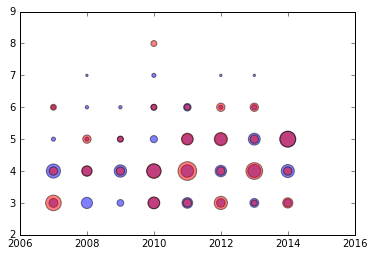

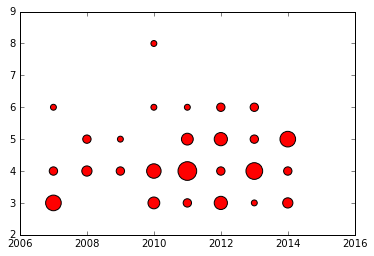

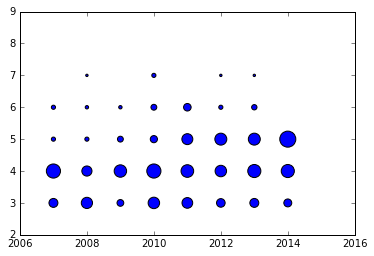

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
x_men,y_men,s_men=scatterCount(men_master_student)
x_women,y_women,s_women=scatterCount(women_master_student)
plt.figure(1)
plt.scatter(y_men,x_men, s_men,alpha=0.5)
plt.scatter(y_women,x_women, s_women,'r',alpha=0.5)

plt.figure(2)
plt.scatter(y_women,x_women, s_women,'r')
plt.figure(3)
plt.scatter(y_men,x_men, s_men,alpha=1)

#plt.show()

(86,)
(525,)


(array([ 125.,    0.,  226.,    0.,    0.,  137.,    0.,   31.,    0.,    6.]),
 array([ 3. ,  3.4,  3.8,  4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ]),
 <a list of 10 Patch objects>)

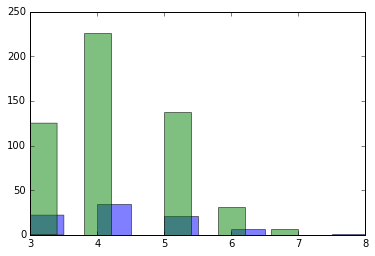

In [120]:
%matplotlib inline

import matplotlib.pyplot as plt

#plt.figure()
#plt.histogram(men_master_student.loc[:,'Time to Finish'].values)

#print(women_master_student['Time to Finish'].values)


#print(women_master_student['Time to Finish'])
#women_master_student['Time to Finish'].hist(bins=20)
#men_master_student['Time to Finish'].hist(bins=20)
print(women_master_student['Time to Finish'].values.shape)
print(men_master_student['Time to Finish'].values.shape)

#data = np.vstack([women_master_student['Time to Finish'].values, men_master_student['Time to Finish'].values])

plt.hist(women_master_student['Time to Finish'].values, alpha=0.5, bins=10, stacked=True)
#plt.hold()
plt.hist(men_master_student['Time to Finish'].values,alpha=0.5, bins=10, stacked=True)


#f, axarr = plt.subplots(2, sharex=True)
#axarr[0].hist(women_master_student['Time to Finish'].values, alpha=0.5, bins=15, stacked=True, color='r')
##axarr[0].set_title('Histogram plot of time taken to finish for each sex')
#axarr[1].hist(men_master_student['Time to Finish'].values,alpha=0.5, bins=15, stacked=True, color='b')
#axarr[0].set_ylabel('Number of \nfemale students')
#axarr[1].set_ylabel('Number of \nmale students')
#axarr[1].set_xlabel('Semesters taken to complete the master')
#plt.show()

We indeed see that the distributions are the same, which agrees with the statistical test that gives no difference of duration beteween men and women.